# Zaimportowane moduły i pliki

In [1]:
import time
import zipfile
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = 'dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_hydrologiczne/dobowe'
zip_files = glob(f'{data_dir}/*/*.zip')     # list of .zip files
zip_files[:5]                               # first five elements

['dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_hydrologiczne/dobowe\\2016\\codz_2016_01.zip',
 'dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_hydrologiczne/dobowe\\2016\\codz_2016_02.zip',
 'dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_hydrologiczne/dobowe\\2016\\codz_2016_03.zip',
 'dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_hydrologiczne/dobowe\\2016\\codz_2016_04.zip',
 'dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_hydrologiczne/dobowe\\2016\\codz_2016_05.zip']

# Ekstrakcja z archiwów .zip
Definicja funkcji rozpakowującej zawartości pliku .zip (plik .csv) do tej samej ścieżki i tworzącej listę rozpakowanych plików .csv.

In [3]:
def unpack(files: list) -> list:
    """Unpacks given file list in the same parent dir.
    Returns list of unpacked files."""
    for file in files:
        with zipfile.ZipFile(file) as zip_file:
            zip_file.extractall(file[:77])

    csv_files = glob(f'{data_dir}/*/*.csv')     # list of .csv files

    return sorted(csv_files)

# Analiza danych

Poniższy skrypt rozpakowuje pliki .zip w pętli, tworzy z nich obiekty DataFrame (tabele), łączy je ze sobą w jedną wielką tabelę, a następnie przyłącza filtrowane po nazwach stacji fragmenty tabeli do słownika wraz z przypisanym im kluczem — nazwą stacji. W zależności od hardware'u i ilości danych do analizy może to zająć trochę czasu, ale za to daje nam później możliwość pracowania z danymi z dowolnej stacji. Dla danych z lat 2016-2018 powinno to zająć około minuty.

In [4]:
start_time = time.time()
codz_names = (
    'Kod stacji',
    'Nazwa stacji',
    'Nazwa rzeki/jeziora',
    'Rok hydrologiczny',
    'Wskaźnik miesiąca w roku hydrologicznym',
    'Dzień',
    'Stan wody [cm]',
    'Przepływ [m^3/s]',
    'Temperatura wody [st. C]',
    'Miesiąc kalendarzowy'
)

DF = pd.DataFrame()
dates = []
stations = []
for file in unpack(zip_files):
    if 'codz_' in file:
        df = pd.read_csv(
            file,
            encoding='windows-1250',
            names=codz_names
        )

        DF = pd.concat([DF, df])

        for station in df['Nazwa stacji']:
            if station not in stations:
                stations.append(station)

DF = {station: (DF[DF['Nazwa stacji'] == station]) for station in stations}

print(f'execution time: {time.time() - start_time} s')

execution time: 52.38820505142212 s


Definicja funkcji konwertującej 3 kolumny zawierające osobne dane o roku, miesiącu i dniu wykonania pomiaru w jedną kolumnę "Data". Funkcja zwraca tabelę z przyłączoną kolumną "Data" oraz usuniętymi kolumnami "Rok hydrologiczny", "Wskaźnik miesiąca w roku hydrologicznym", "Dzień" oraz "Miesiąc kalendarzowy".

In [5]:
def date_creator(df: pd.DataFrame) -> pd.DataFrame:
    """Takes year, month and day cols and combines them into date col (YYYY-MM-dd format).
    Inserts date col into df and drops year, month and day cols."""

    dates = []
    df = df.set_index(i for i in range(len(df['Kod stacji'])))
    for idx, row in enumerate(df['Rok hydrologiczny']):
        date = f"{row}.{df['Wskaźnik miesiąca w roku hydrologicznym'][idx]:02d}.{df['Dzień'][idx]:02d}"
        dates.append(date)

    df.insert(value=dates, column='Data', loc=3)

    df = df.drop(
        axis=1,
        labels=[
            'Rok hydrologiczny',
            'Wskaźnik miesiąca w roku hydrologicznym',
            'Dzień',
            'Miesiąc kalendarzowy'
        ]
    )
    return df

In [6]:
krk_bielany = date_creator(DF['KRAKÓW-BIELANY'])
czernichow_prom = date_creator(DF['CZERNICHÓW-PROM'])

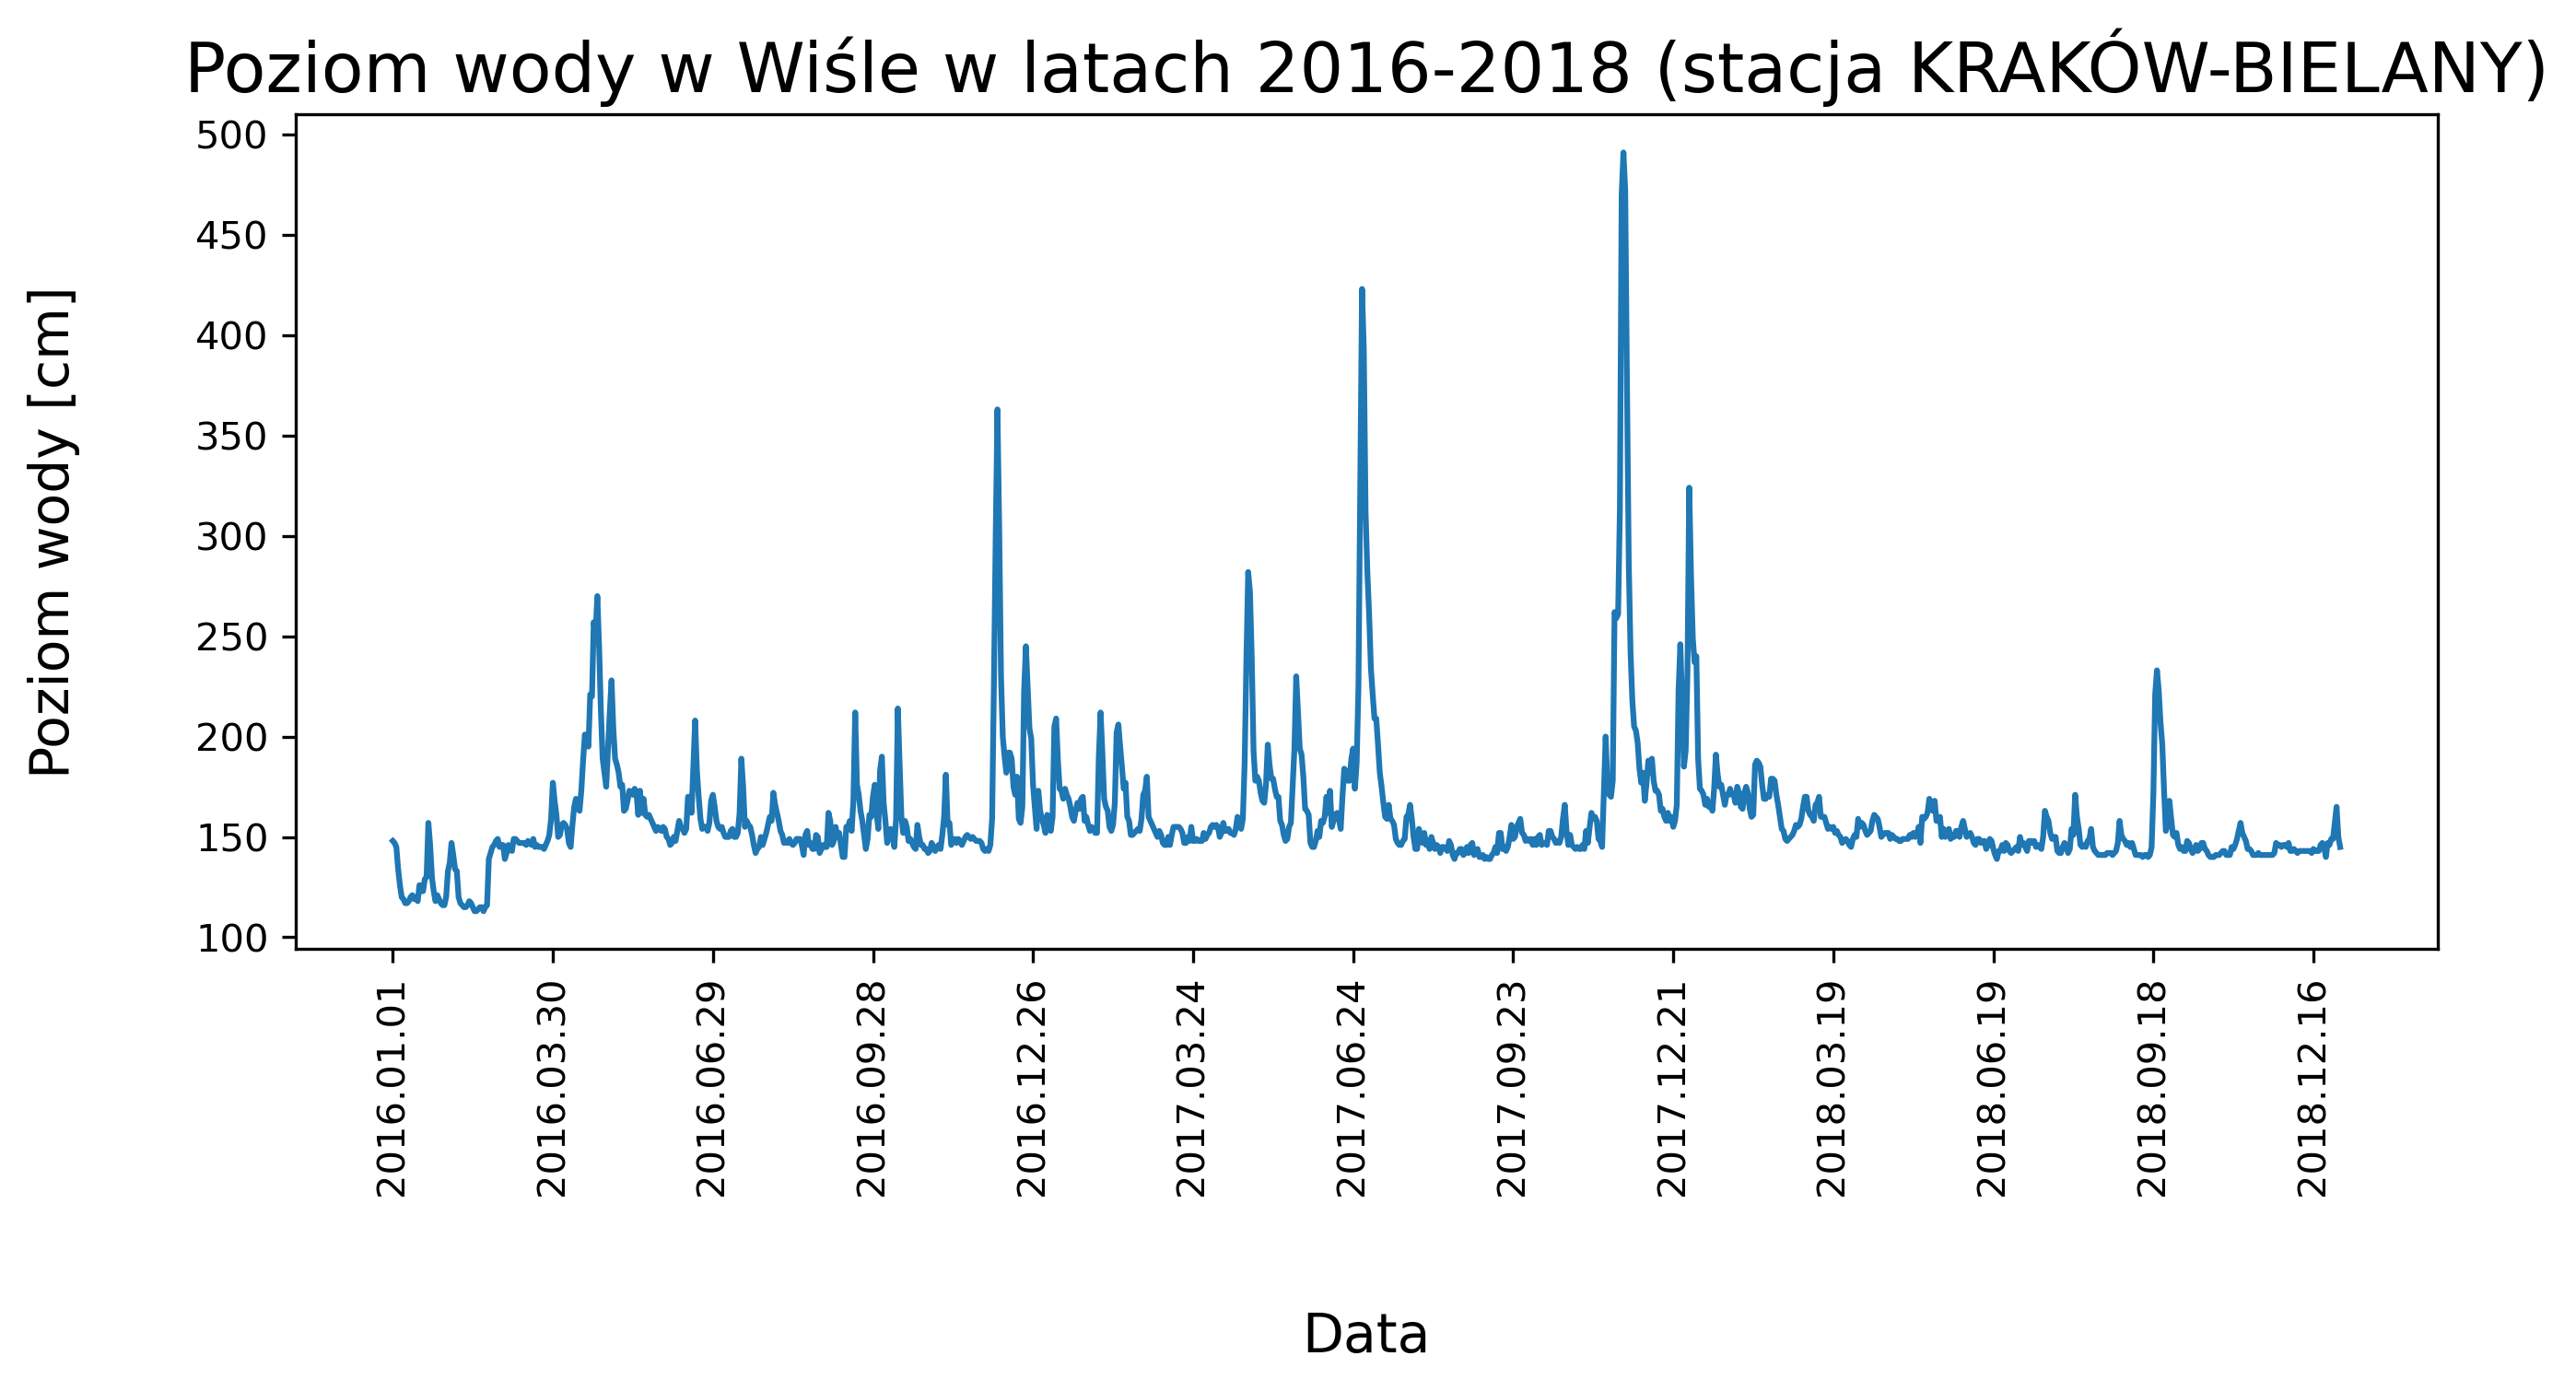

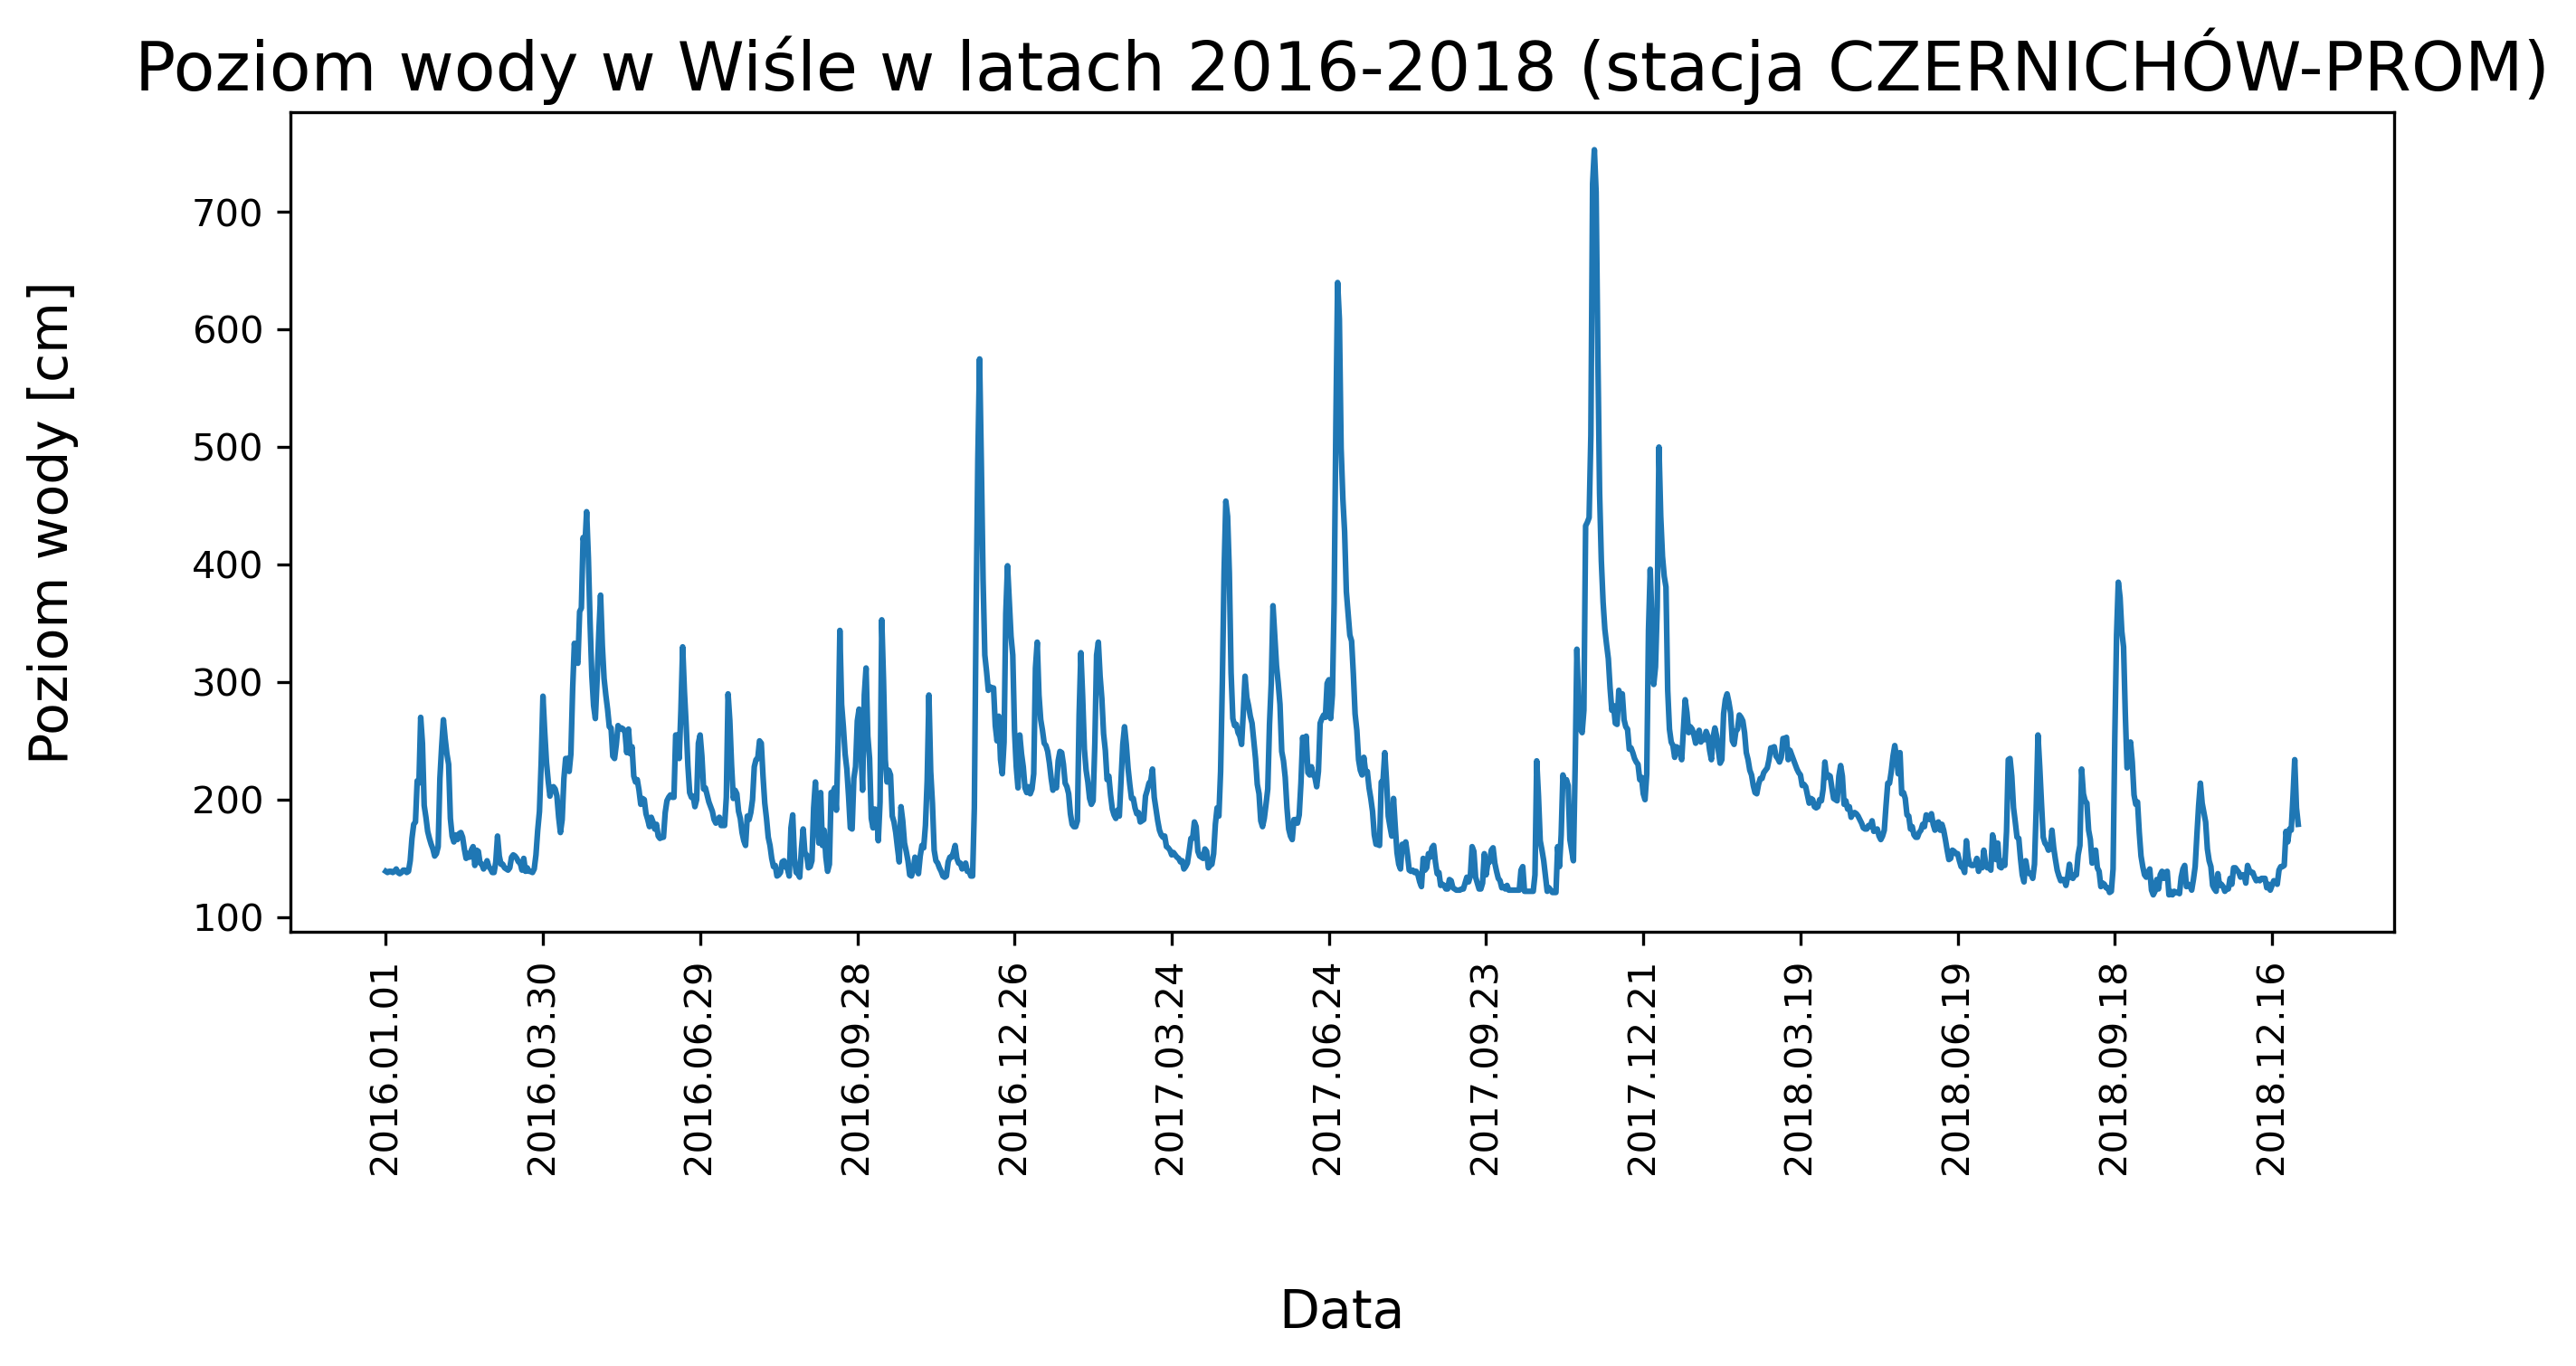

In [7]:
def plot_wlevel(df: pd.DataFrame):
    fig = plt.figure(figsize=(10, 4), dpi=300, facecolor='#ffffff')
    plt.plot(
        df['Data'],
        df['Stan wody [cm]'],
    )
    plt.title(f'Poziom wody w Wiśle w latach 2016-2018 (stacja {df["Nazwa stacji"][0]})', fontdict={'fontsize': 18})
    plt.ylabel('Poziom wody [cm]', fontdict={'fontsize': 14}, labelpad=30)
    plt.xlabel('Data', fontdict={'fontsize': 14}, labelpad=30)
    plt.xticks(df['Data'][::90], rotation=90)
    plt.savefig(f'output/fig-{df["Nazwa stacji"][0]}.png', bbox_inches='tight')
    plt.show()
    plt.close(fig)


plot_wlevel(krk_bielany)
plot_wlevel(czernichow_prom)

In [ ]:
czernichow_prom2016 =

In [ ]:
fig1 = plt.figure(figsize=(10, 6), dpi=100, facecolor='#ffffff')
plt.plot(
    KRK_BIELANY['Data'],
    KRK_BIELANY['Stan wody [cm]'],
)
plt.title('Poziom wody w Wiśle w latach 2016-2018 (stacja Kraków-Bielany)', fontdict={'fontsize': 18})
plt.ylabel('Poziom wody [cm]', fontdict={'fontsize': 14}, labelpad=30)
plt.xlabel('Data', fontdict={'fontsize': 14}, labelpad=30)
plt.xticks(KRK_BIELANY['Data'][::90], rotation=90)
plt.savefig('output/fig1.png', bbox_inches='tight')
plt.show()
plt.close(fig1)

In [ ]:
fig1 = plt.figure(figsize=(10, 6), dpi=100, facecolor='#ffffff')
plt.plot(
    KRK_BIELANY['Data'],
    KRK_BIELANY['Stan wody [cm]'],
)
plt.title('Poziom wody w Wiśle w latach 2016-2018 (stacja Kraków-Bielany)', fontdict={'fontsize': 18})
plt.ylabel('Poziom wody [cm]', fontdict={'fontsize': 14}, labelpad=30)
plt.xlabel('Data', fontdict={'fontsize': 14}, labelpad=30)
plt.xticks(KRK_BIELANY['Data'][::90], rotation=90)
plt.savefig('output/fig1.png', bbox_inches='tight')
plt.show()
plt.close(fig1)

In [ ]:
fig1 = plt.figure(figsize=(10, 6), dpi=100, facecolor='#ffffff')
plt.plot(
    KRK_BIELANY['Data'],
    KRK_BIELANY['Stan wody [cm]'],
)
plt.title('Poziom wody w Wiśle w latach 2016-2018 (stacja Kraków-Bielany)', fontdict={'fontsize':18})
plt.ylabel('Poziom wody [cm]', fontdict={'fontsize':14}, labelpad=30)
plt.xlabel('Data', fontdict={'fontsize':14}, labelpad=30)
plt.xticks(KRK_BIELANY['Data'][::90], rotation=90)
plt.savefig('output/fig1.png', bbox_inches='tight')
plt.show()
plt.close(fig1)